# Attempt at ensembling other regressors

In [79]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error



from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

from xgboost import XGBRegressor



import pickle
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Import

In [2]:
df = pd.read_csv('../data/1500_sentiment_api.csv')
df.head(5)

,id,latitude,longitude,price,shared_status,accommodates,accomodation_group,bathrooms,bedrooms,beds_adjusted,neighborhood,has_neighborhood_overview,has_reviews,listing_url,host_in_CO,host_lives_in_neighborhood,host_id,host_name,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,has_host_about,years_hosting,years_of_reviews,license_listed,response_time,host_lives_in_neighborhood.1,name,host_about,description,neighborhood_overview,amenities,minimum_nights,maximum_nights,min_stay_group,max_stay_group,has_availability,instant_bookable,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bike_scores,walk_scores,property_page_links,transit_scores,name_sent_compound,name_sent_pos,name_sent_neg,name_sent_neu,host_sent_compound,host_sent_pos,host_sent_neg,host_sent_neu,description_sent_compound,description_sent_pos,description_sent_neg,description_sent_neu,neighborhood_sent_compound,neighborhood_sent_pos,neighborhood_sent_neg,neighborhood_sent_neu,25*k
0,177,39.69551,-104.92489,79.0,entire home,2,0-2,1.0,1.0,1.0,Virginia Village,1,1,https://www.airbnb.com/rooms/177,1,1,615,Joe,within an hour,1.0,1.00,1.0,Virginia Village,2.0,2.0,1.0,0.0,1,15.0,6.0,1,0.0,1,Tiny Home in the Heart of the City- ECO FRIENDLY,"I'm originally from Oklahoma, but have lived i...","160 sq ft + 80 sq ft loft for sleeping, Sleeps...","Quiet neighborhood next to park, creeks and bi...","[""Hot water"", ""Long term stays allowed"", ""Coff...",29,400,month,long_term,1,0,120,24,0,4.85,4.96,4.89,4.97,4.94,4.85,4.78,1.56,84.0,51.0,https://www.walkscore.com/score/loc/lat=39.695...,37.0,0.6037,0.304,0.0,0.696,0.6948,0.192,0.000,0.808,0.9476,0.153,0.069,0.778,0.0000,0.000,0.000,1.000,4.0
1,360,39.76758,-105.00316,133.0,entire home,3,3-4,1.0,2.0,2.0,Highland,1,1,https://www.airbnb.com/rooms/360,1,1,666,Jennifer & Giovanni,within an hour,1.0,0.87,1.0,Highland,4.0,4.0,1.0,1.0,1,15.0,4.0,1,0.0,1,Sit in the Peaceful Garden of the Chickadee Co...,We are artists and tinkerers.\r\n \r\nWe enjoy...,Enjoy the famous Colorado weather and unplug i...,The cottage is located in the center of Lower ...,"[""Coffee maker"", ""Washer"", ""Bedroom comforts"",...",29,35,month,2_months,1,0,174,7,1,4.99,4.99,4.96,5.00,5.00,5.00,4.91,3.26,93.0,90.0,https://www.walkscore.com/score/loc/lat=39.767...,49.0,0.4939,0.242,0.0,0.758,0.9694,0.141,0.023,0.835,0.9814,0.271,0.019,0.709,0.1531,0.025,0.018,0.956,6.0
2,2361919,39.77960,-105.03859,76.0,entire home,2,0-2,1.0,1.0,1.0,Berkeley,1,1,https://www.airbnb.com/rooms/2361919,1,1,5811115,Annette,within a few hours,1.0,0.81,1.0,Berkeley,5.0,6.0,1.0,0.0,1,10.0,8.0,0,1.0,1,The Cloisters at Berkeley,"I love people of all ages and types, dogs, lon...",A private studio apartment in an unbeatable ne...,"Boutiques, bars, restaurants galore! Highlands...","[""Hot water"", ""Long term stays allowed"", ""Coff...",30,1125,month,long_term,1,0,43,3,0,4.67,4.74,4.56,4.67,4.60,4.93,4.60,0.40,76.0,81.0,https://www.walkscore.com/score/loc/lat=39.779...,34.0,0.0000,0.000,0.0,1.000,0.9769,0.278,0.000,0.722,0.9269,0.150,0.000,0.850,0.4333,0.067,0.026,0.907,4.0
3,2386289,39.76777,-105.03529,150.0,entire home,4,3-4,1.0,1.0,1.0,West Highland,1,1,https://www.airbnb.com/rooms/2386289,1,1,184771,Melanie,NaN,NaN,1.00,0.0,West Highland,1.0,2.0,1.0,1.0,1,13.0,8.0,1,4.0,1,Sunny Sky Loft in Highlands,"Things I love: dogs, urban gardening, yoga, ho...",Why stay in a stuffy old hotel room when you c...,The neighborhood where the house is located is...,"[""Hot water"", ""Long term stays allowed"", ""Coff...",7,30,week,month,1,0,95,1,0,4.91,4.87,4.89,4.96,4.97,4.93,4.83,0.94,75.0,86.0,https://www.walkscore.com/score/loc/lat=39.767...,39.0,0.4215,0.412,0.0,0.588,0.9716,0.24

In [3]:
df.columns

Index(['id', 'latitude', 'longitude', 'price', 'shared_status', 'accommodates',
       'accomodation_group', 'bathrooms', 'bedrooms', 'beds_adjusted',
       'neighborhood', 'has_neighborhood_overview', 'has_reviews',
       'listing_url', 'host_in_CO', 'host_lives_in_neighborhood', 'host_id',
       'host_name', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'has_host_about',
       'years_hosting', 'years_of_reviews', 'license_listed', 'response_time',
       'host_lives_in_neighborhood.1', 'name', 'host_about', 'description',
       'neighborhood_overview', 'amenities', 'minimum_nights',
       'maximum_nights', 'min_stay_group', 'max_stay_group',
       'has_availability', 'instant_bookable', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating

### Creating a model

In [4]:
X = df[[
    'shared_status', 
    'accommodates',
    'bathrooms', 
    'bedrooms',
    'beds_adjusted',
    'neighborhood', 
    'has_neighborhood_overview', 
    'has_reviews',
    'instant_bookable',
    'host_lives_in_neighborhood',
     'host_is_superhost', 
    'host_has_profile_pic',
    'host_identity_verified', 
    'has_host_about', 
    'years_hosting',
    'license_listed', 
    'minimum_nights',
    'maximum_nights',
     'number_of_reviews',
     'bike_scores',
    'walk_scores',
    'transit_scores',
    'host_sent_compound', 
    'description_sent_compound', 
    'neighborhood_sent_compound',
]]
    
    


y = df['price']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2022)

# I want to try a Bagged Extra trees
Apparently a transformedtargetregressor works well when the traget is not normally distributed, like my price data 

In [7]:

# define the pipeline as before
numeric_features = list(X.select_dtypes(include='number').columns)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = list(X.select_dtypes(include='object').columns)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# TransformerTarget with extra trees
estimator = TransformedTargetRegressor(
    regressor=ExtraTreesRegressor(),
    transformer=StandardScaler()
)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('estimator', estimator)])

In [8]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['accommodates', 'bathrooms',
                                                   'bedrooms', 'beds_adjusted',
                                                   'has_neighborhood_overview',
                                                   'has_reviews',
                                                   'instant_bookable',
                                                   'host_lives_in_neighborhood',
                                                   'host_is_superhost',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'has_host_ab

In [10]:
y_pred_train = pipe.predict(X_train)
rmse_train = (mean_squared_error(y_train, y_pred_train))**0.5
print("Train RMSE:", rmse_train)

y_pred = pipe.predict(X_test)
rmse = (mean_squared_error(y_test, y_pred))**0.5
print("Test RMSE:", rmse)

Train RMSE: 0.46429063765163037
Test RMSE: 92.35738360432052


In [11]:
pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('scaler', StandardScaler())]),
                                    ['accommodates', 'bathrooms', 'bedrooms',
                                     'beds_adjusted', 'has_neighborhood_overview',
                                     'has_reviews', 'instant_bookable',
                                     'host_lives_in_neighborhood',
                                     'host_is_superhost', 'host_has_profile_pic',
                                     'host_identity_verified', 'has_host_about',
                                     'years_hosting', 'license_listed',
                                     'minimum_nights', 'maximum_nights',
                                     'number_of_reviews', 'bike_scores',
                                     'walk_scores', 'transit_scores',
                                     'host_sent_compound',
                  

In [12]:
b_params = {
    
    'estimator__regressor__n_estimators':[100, 200, 300, 400, 500],
    'estimator__regressor__max_samples': [.1, .3, .5, .7, 1],
    'estimator__regressor__max_features': [8,10,None],
    'estimator__regressor__bootstrap': [True]
}

In [13]:
gs= GridSearchCV(pipe, param_grid=b_params, cv=5)

In [14]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['accommodates',
                                                                          'bathrooms',
                                                                          'bedrooms',
                                                                          'beds_adjusted',
                                                                          'has_neighborhood_overview',
                                                                          'has_reviews',
                                                                          'instant_booka

In [15]:
gs.best_params_

{'estimator__regressor__bootstrap': True,
 'estimator__regressor__max_features': None,
 'estimator__regressor__max_samples': 0.7,
 'estimator__regressor__n_estimators': 400}

In [16]:
y_pred = gs.predict(X_test)
rmse = (mean_squared_error(y_test, y_pred))**0.5
print("RMSE:", rmse)
# no better than the other models. 

RMSE: 86.89463353313623


# trying a Bagged Gradient Boost
First to see if there is potential

In [ ]:
numeric_features = list(X.select_dtypes(include='number').columns)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = list(X.select_dtypes(include='object').columns)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

#start with n=10 estimators, just to see how it performs...
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', BaggingRegressor(base_estimator=GradientBoostingRegressor(), n_estimators=10))
])


pipeline.fit(X, y)


In [19]:
y_pred_train = pipeline.predict(X_train)
rmse_train = (mean_squared_error(y_train, y_pred_train))**0.5
print("Train RMSE:", rmse_train)

y_pred = pipeline.predict(X_test)
rmse = (mean_squared_error(y_test, y_pred))**0.5
print("Test RMSE:", rmse)
#better from the start!!

Train RMSE: 76.79162298411246
Test RMSE: 70.82437315297533


In [20]:
pipeline.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['accommodates', 'bathrooms',
                                                   'bedrooms', 'beds_adjusted',
                                                   'has_neighborhood_overview',
                                                   'has_reviews',
                                                   'instant_bookable',
                                                   'host_lives_in_neighborhood',
                                                   'host_is_superhost',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                          

# Gridsearch to see if we can improve parameters

In [27]:
numeric_features = list(X.select_dtypes(include='number').columns)
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = list(X.select_dtypes(include='object').columns)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', BaggingRegressor(base_estimator=GradientBoostingRegressor()))
])


In [28]:
params_GB = {
    'model__n_estimators': [10, 50, 100],
    'model__base_estimator__learning_rate': [0.1, 0.01],
    'model__base_estimator__max_depth': [2, 4, 6],
}

In [29]:
grid_search = GridSearchCV(pipeline, param_grid=params_GB, cv=5)
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['accommodates',
                                                                          'bathrooms',
                                                                          'bedrooms',
                                                                          'beds_adjusted',
                                                                          'has_neighborhood_overview',
                                                                          'has_reviews',
                                                                          'instant_booka

In [30]:
y_pred_train = grid_search.predict(X_train)
rmse_train = (mean_squared_error(y_train, y_pred_train))**0.5
print("Train RMSE:", rmse_train)

y_pred = grid_search.predict(X_test)
rmse = (mean_squared_error(y_test, y_pred))**0.5
print("Test RMSE:", rmse)
#bet model yet!!  

Train RMSE: 68.35204120792483
Test RMSE: 63.92548079952287


In [31]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['accommodates', 'bathrooms',
                                                   'bedrooms', 'beds_adjusted',
                                                   'has_neighborhood_overview',
                                                   'has_reviews',
                                                   'instant_bookable',
                                                   'host_lives_in_neighborhood',
                                                   'host_is_superhost',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'has_host_ab

In [46]:
grid_search.best_params_

{'model__base_estimator__learning_rate': 0.1,
 'model__base_estimator__max_depth': 4,
 'model__n_estimators': 100}

In [33]:
# with open('../pickle/bagged_GB.pkl', 'wb') as f:
#     pickle.dump(grid_search.best_estimator_, f)

In [34]:
grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['num']

Pipeline(steps=[('scaler', StandardScaler())])

In [35]:
grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']

OneHotEncoder(handle_unknown='ignore')

In [36]:
# numeric_feature_names=
numeric_transformer.get_feature_names_out(numeric_features)


array(['accommodates', 'bathrooms', 'bedrooms', 'beds_adjusted',
       'has_neighborhood_overview', 'has_reviews', 'instant_bookable',
       'host_lives_in_neighborhood', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified', 'has_host_about',
       'years_hosting', 'license_listed', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'bike_scores',
       'walk_scores', 'transit_scores', 'host_sent_compound',
       'description_sent_compound', 'neighborhood_sent_compound'],
      dtype=object)

In [37]:
all_features = grid_search.best_estimator_[:-1].get_feature_names_out()

In [38]:
bagging_model = grid_search.best_estimator_.named_steps['model']

# Access the decision tree models that were trained during the bagging process
estimators = bagging_model.estimators_

# Get the feature importances for each decision tree model
importances = []
for estimator in estimators:
    importances.append(estimator.feature_importances_)

# Average the importance scores across all decision tree models
importances = np.mean(importances, axis=0)

#chat

In [39]:
df_plot = pd.DataFrame({'all_features': all_features,
                   'feature_importance': importances})

In [40]:
df_plot.head()

,all_features,feature_importance
0,num__accommodates,0.091712
1,num__bathrooms,0.351975
2,num__bedrooms,0.144889
3,num__beds_adjusted,0.039489
4,num__has_neighborhood_overview,0.001725


In [41]:
df_plot['all_features']=df_plot['all_features'].str[5:]


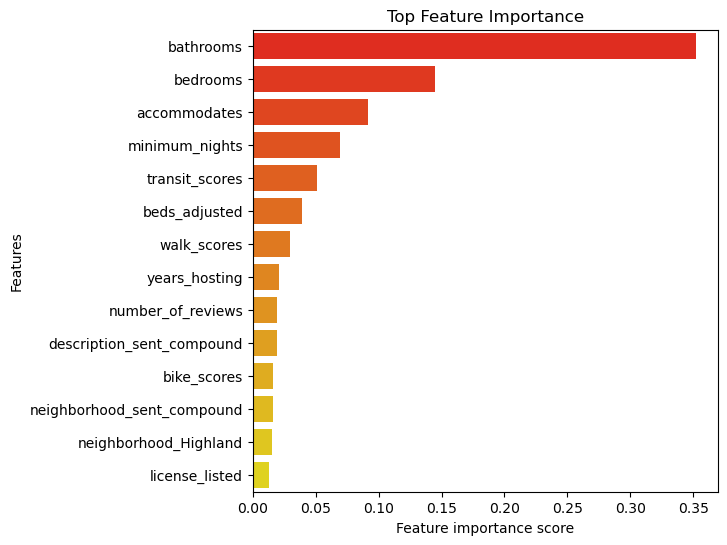

''

In [42]:
feature_scores = pd.Series(importances, index=df_plot['all_features']).sort_values(ascending=False).head(14)

f, ax = plt.subplots(figsize=(6, 6))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df, palette='autumn')
ax.set_title("Top Feature Importance")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
# plt.savefig('../images/bagged_GD_feature_importance.png', bbox_inches='tight')

plt.show()
;


/Users/carl/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


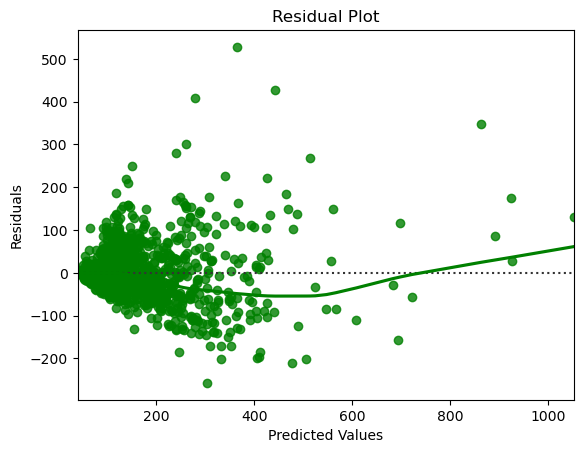

In [45]:
#we're here, might as well make a residual plot. This is on the test data. 
y_predz = grid_search.predict(X_test)


sns.residplot(y_predz, y_test, lowess=True, color="g")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

#not that good... 

/Users/carl/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


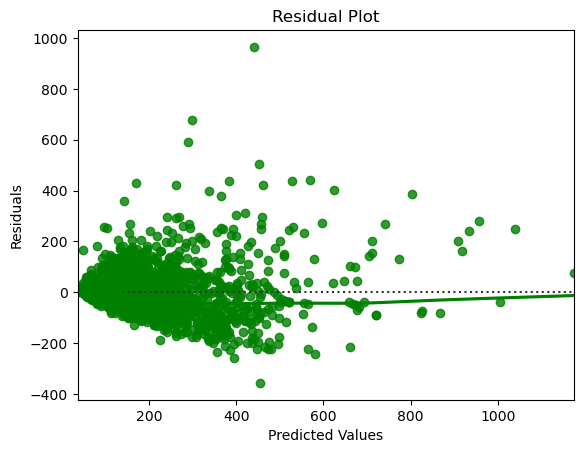

In [44]:

# train data, just to see 
y_predict = grid_search.predict(X_train)

# Create a residual plot
sns.residplot(y_predict, y_train, lowess=True, color="g")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# A few parameters were on the upper/lower limits of what was given, let's expained the parameter range

In [51]:
numeric_features2 = list(X.select_dtypes(include='number').columns)
numeric_transformer2 = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features2 = list(X.select_dtypes(include='object').columns)
categorical_transformer2 = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor2 = ColumnTransformer(transformers=[
    ('num', numeric_transformer2, numeric_features2),
    ('cat', categorical_transformer2, categorical_features2)])

pipeline2 = Pipeline(steps=[
    ('preprocessor', preprocessor2),
    ('model', BaggingRegressor(base_estimator=GradientBoostingRegressor()))
])


In [52]:
params2 = {
    'model__n_estimators': [100, 200, 400],
    'model__base_estimator__learning_rate': [0.1],
    'model__base_estimator__max_depth': [3, 4, 5],
}

In [53]:
grid_search2 = GridSearchCV(pipeline2, param_grid=params2, cv=5)
grid_search2.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['accommodates',
                                                                          'bathrooms',
                                                                          'bedrooms',
                                                                          'beds_adjusted',
                                                                          'has_neighborhood_overview',
                                                                          'has_reviews',
                                                                          'instant_booka

In [76]:
y_pred_train = grid_search2.predict(X_train)
rmse_train = (mean_squared_error(y_train, y_pred_train))**0.5
print("Train RMSE:", rmse_train)

y_pred = grid_search2.predict(X_test)
rmse = (mean_squared_error(y_test, y_pred))**0.5
print("Test RMSE:", rmse)
# better yet!!

Train RMSE: 60.56621495034654
Test RMSE: 57.60889593374656


In [63]:
grid_search2.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['accommodates', 'bathrooms',
                                                   'bedrooms', 'beds_adjusted',
                                                   'has_neighborhood_overview',
                                                   'has_reviews',
                                                   'instant_bookable',
                                                   'host_lives_in_neighborhood',
                                                   'host_is_superhost',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'has_host_ab

In [64]:
grid_search2.best_params_

{'model__base_estimator__learning_rate': 0.1,
 'model__base_estimator__max_depth': 5,
 'model__n_estimators': 400}

In [33]:
# with open('../pickle/bagged_GB.pkl', 'wb') as f:
#     pickle.dump(grid_search.best_estimator_, f)

In [65]:
grid_search2.best_estimator_.named_steps['preprocessor'].named_transformers_['num']

Pipeline(steps=[('scaler', StandardScaler())])

In [66]:
grid_search2.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']

OneHotEncoder(handle_unknown='ignore')

In [67]:
# numeric_feature_names=
numeric_transformer2.get_feature_names_out(numeric_features2)


array(['accommodates', 'bathrooms', 'bedrooms', 'beds_adjusted',
       'has_neighborhood_overview', 'has_reviews', 'instant_bookable',
       'host_lives_in_neighborhood', 'host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified', 'has_host_about',
       'years_hosting', 'license_listed', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'bike_scores',
       'walk_scores', 'transit_scores', 'host_sent_compound',
       'description_sent_compound', 'neighborhood_sent_compound'],
      dtype=object)

In [68]:
all_features = grid_search2.best_estimator_[:-1].get_feature_names_out()

In [69]:
bagging_model = grid_search2.best_estimator_.named_steps['model']

# Access the decision tree models that were trained during the bagging process
estimators = bagging_model2.estimators_

# Get the feature importances for each decision tree model
importances = []
for estimator in estimators:
    importances.append(estimator.feature_importances_)

# Average the importance scores across all decision tree models
importances = np.mean(importances, axis=0)

#chat

In [70]:
df_plot = pd.DataFrame({'all_features': all_features,
                   'feature_importance': importances})

In [71]:
df_plot.head()

,all_features,feature_importance
0,num__accommodates,0.084946
1,num__bathrooms,0.336897
2,num__bedrooms,0.128243
3,num__beds_adjusted,0.039009
4,num__has_neighborhood_overview,0.002295


In [72]:
df_plot['all_features']=df_plot['all_features'].str[5:]


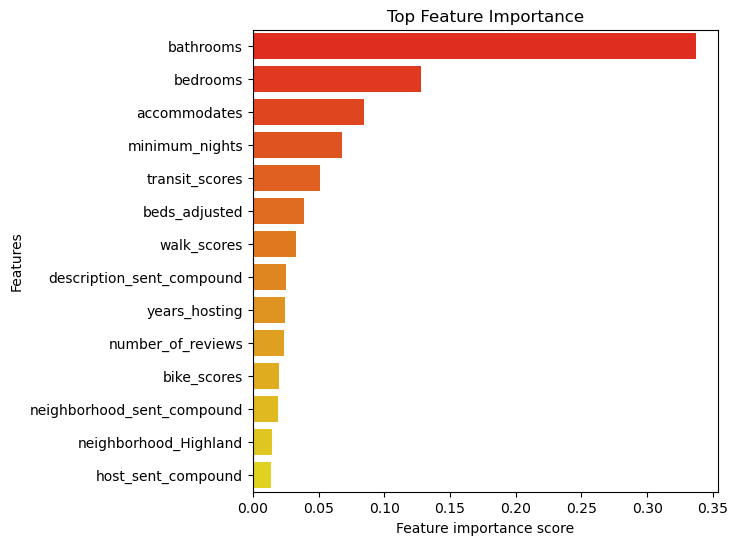

''

In [74]:
feature_scores = pd.Series(importances, index=df_plot['all_features']).sort_values(ascending=False).head(14)

f, ax = plt.subplots(figsize=(6, 6))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df, palette='autumn')
ax.set_title("Top Feature Importance")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.savefig('../images/bagged_GD_final.png', bbox_inches='tight')

plt.show()
;


/Users/carl/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


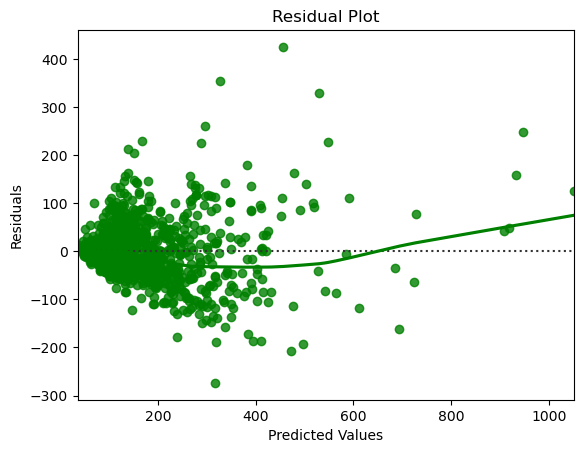

In [77]:
#we're here, might as well make a residual plot
y_predz = grid_search2.predict(X_test)


sns.residplot(y_predz, y_test, lowess=True, color="g")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

#better

# XG Boost

In [80]:
numeric_features3 = list(X.select_dtypes(include='number').columns)
numeric_transformer3 = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features3 = list(X.select_dtypes(include='object').columns)
categorical_transformer3 = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor3 = ColumnTransformer(transformers=[
    ('num', numeric_transformer2, numeric_features2),
    ('cat', categorical_transformer2, categorical_features2)])

pipeline3 = Pipeline(steps=[
    ('preprocessor', preprocessor2),
    ('model', BaggingRegressor(base_estimator=XGBRegressor()))
])


In [81]:
pipeline3.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['accommodates', 'bathrooms',
                                                   'bedrooms', 'beds_adjusted',
                                                   'has_neighborhood_overview',
                                                   'has_reviews',
                                                   'instant_bookable',
                                                   'host_lives_in_neighborhood',
                                                   'host_is_superhost',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'has_host_ab

In [83]:
y_pred_train = pipeline3.predict(X_train)
rmse_train = (mean_squared_error(y_train, y_pred_train))**0.5
print("Train RMSE:", rmse_train)

y_pred = pipeline3.predict(X_test)
rmse = (mean_squared_error(y_test, y_pred))**0.5
print("Test RMSE:", rmse)

Train RMSE: 43.839196965679065
Test RMSE: 81.43117069187767


In [ ]:
pipeline3

In [104]:
pipeline3.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('scaler', StandardScaler())]),
                                    ['accommodates', 'bathrooms', 'bedrooms',
                                     'beds_adjusted', 'has_neighborhood_overview',
                                     'has_reviews', 'instant_bookable',
                                     'host_lives_in_neighborhood',
                                     'host_is_superhost', 'host_has_profile_pic',
                                     'host_identity_verified', 'has_host_about',
                                     'years_hosting', 'license_listed',
                                     'minimum_nights', 'maximum_nights',
                                     'number_of_reviews', 'bike_scores',
                                     'walk_scores', 'transit_scores',
                                     'host_sent_compound',
                  

In [105]:
paramsXG = {
    'model__n_estimators': [5, 20, 40],
    'model__base_estimator__learning_rate' : [None, 0.1],
    'model__base_estimator__max_depth': [None, 3, 5]
}

In [ ]:
gsXG = GridSearchCV(pipeline3, param_grid=paramsXG, cv=5)
gsXG.fit(X, y)